In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, vstack
from astropy.wcs import WCS

import os
from os import getpid

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, Rectangle

from matplotlib.lines import Line2D

import xspec as x

import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.autonotebook import tqdm

import multiprocessing
import datetime

import scipy.odr as odr

from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from IPython.display import clear_output

/home/aleksei/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/aleksei/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_12541/3202773982.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Catalogues of clusters and photon lists:

In [2]:
clusters_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+', header=0)
clusters = clusters_all[clusters_all["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]

wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

clusters

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


In [64]:
clusters[clusters["ihal"]==46]
cd = clusters.loc[13675]
360+30*cd["x_pix"]-5, 30*cd["y_pix"]-5

(356.80620847, 11.7601258)

In [3]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\s+', header=2)


binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
    
    for ind in clusters.index:

        zt = clusters.loc[ind]["z_true"]

        if zt > borders[0] and zt < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
#sorted(binned_clusters.items())

redshifts = [clusters.loc[i]["z_true"] for i in clusters.index]

geometry

,snapNr,ztab,zslice,z_start,z_end,x0,y0,z0,depth,width
0,144,0.001001,0.008625,0.000000,0.017281,230.604600,52.929941,38.137176,73.327162,21.167728
1,140,0.033671,0.033822,0.017281,0.050478,305.341400,149.855590,172.109480,139.387980,82.573299
2,136,0.067408,0.067555,0.050478,0.084760,97.871486,134.586170,117.805860,141.855220,163.761220
3,132,0.102245,0.102388,0.084760,0.120158,185.353850,229.067940,294.134880,144.222380,246.344710
4,128,0.138220,0.138357,0.120158,0.156713,146.337120,179.784950,264.241690,146.478010,330.262680
5,124,0.175368,0.175501,0.156713,0.194460,170.716390,187.570430,175.891600,148.610980,415.447530


In [4]:
galaxies_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/galaxies.dat", sep='\s+', header=0)
galaxies_all

,isub,x_pix,y_pix,z_pix,vmax,z_true,z_obs,Mstar,sfr,u,...,z,Y,J,H,K,L,M,Age,Z,flag
0,201683,0.962549,0.467828,-0.002068,482.064,0.156636,0.156890,43.348600,3.053100,-22.5014,...,-24.7014,-24.9937,-25.3885,-26.0246,-26.2821,-26.4280,-26.4574,0.269562,1.053180,1
1,294417,0.308135,0.547052,-0.001271,394.019,0.156666,0.158137,30.742500,0.000000,-21.9320,...,-24.3703,-24.6621,-25.0561,-25.6940,-25.9519,-26.0967,-26.1231,0.312990,1.006500,1
2,428854,0.239429,0.219663,-0.000989,316.786,0.156676,0.156816,16.174300,0.000000,-21.2007,...,-23.6519,-23.9443,-24.3406,-24.9775,-25.2325,-25.3763,-25.4013,0.316229,1.001770,1
3,260150,0.176925,0.999731,-0.000952,413.087,0.156678,0.155405,43.030700,0.000000,-22.2601,...,-24.7233,-25.0224,-25.4214,-26.0616,-26.3205,-26.4663,-26.4947,0.316437,1.050650,1
4,441383,0.756445,0.922726,-0.000933,259.644,0.156678,0.156527,9.024170,0.000000,-20.4671,...,-22.9383,-23.2374,-23.6374,-24.2763,-24.5329,-24.6785,-24.7070,0.267401,1.092940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632086,1638584,0.090051,0.010463,0.999554,119.088,0.050463,0.050948,0.256724,0.279066,-19.6446,...,-20.0053,-20.1091,-20.3440,-20.8969,-21.1480,-21.2692,-21.2597,0.617970,0.200753,0
632087,1417538,0.133690,0.629479,0.999680,124.889,0.050467,0.051280,0.365516,0.872128,-20.8601,...,-21.0364,-21.2277,-21.5090,-22.1232,-22.4427,-22.6011,-22.6442,0.760209,0.531133,0
632088,197071,0.984320,0.001112,0.999711,113.671,0.050468,0.046894,0.280967,1.032990,-19.3255,...,-20.9473,-21.1335,-21.3442,-22.0208,-22.4384,-22.6206,-22.6835,0.799404,0.305648,0
632089,1182914,0.523695,0.528769,1.000098,130.264,0.050481,0.051212,1.220900,0.532199,-20.7506,...,-21.8453,-22.1433,-22.5103,-23.1606,-23.4823,-23.6515,-23.7068,0.665157,0.810235,1


### Single cluster

<Figure size 640x480 with 0 Axes>

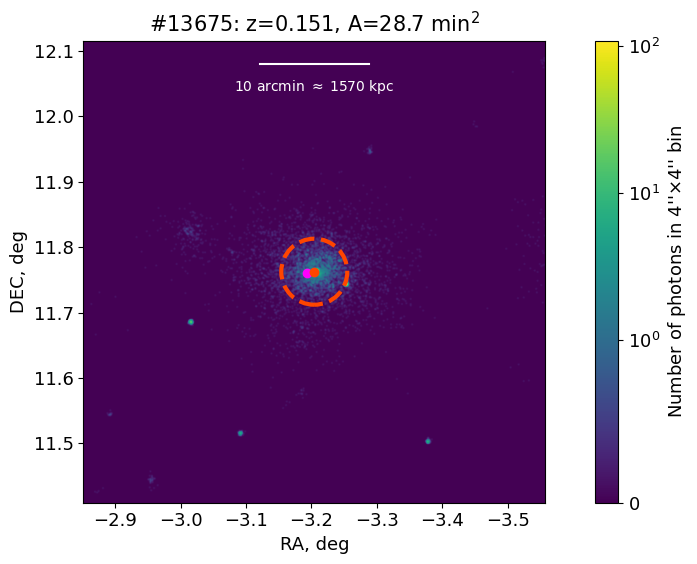

In [65]:
%run -i 'scripts.py'

plt.figure(figsize=(16,6))

cl_num = 13675
RRR = 1.0

#plt.subplot(121)
pho_hist = extract_photons_from_cluster(cl_num, 
                                        r = RRR, 
                                        centroid=True, 
                                        delete_superfluous=False, 
                                        draw=True,
                                        draw_additional=False)

#plt.subplot(122)
#pho_hist = extract_photons_from_cluster(cl_num, 
#                                        r = RRR, 
#                                        centroid=True, 
#                                        delete_superfluous=True, 
#                                        draw=True,
#                                        draw_additional=False)

plt.show()

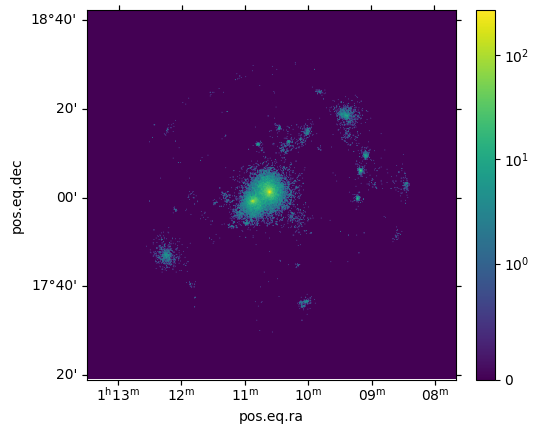

In [28]:
hdul =  fits.open("erosita_img_124.fits")[0]

hdr = hdul.header
image_data = hdul.data

wcs = WCS(hdr)

#display(clusters.iloc[np.where(np.abs(30*clusters["x_pix"]-5 - 17.6465) < 0.001)])

#image_data = fits.getdata("erosita_img_124.fits", ext=0)

#plt.figure(figsize=(16,6))
plt.subplot(projection=wcs)
plt.imshow(image_data, origin="lower", norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1))
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [40]:
from astropy import units as u
from astropy.coordinates import Angle

<Figure size 640x480 with 0 Axes>

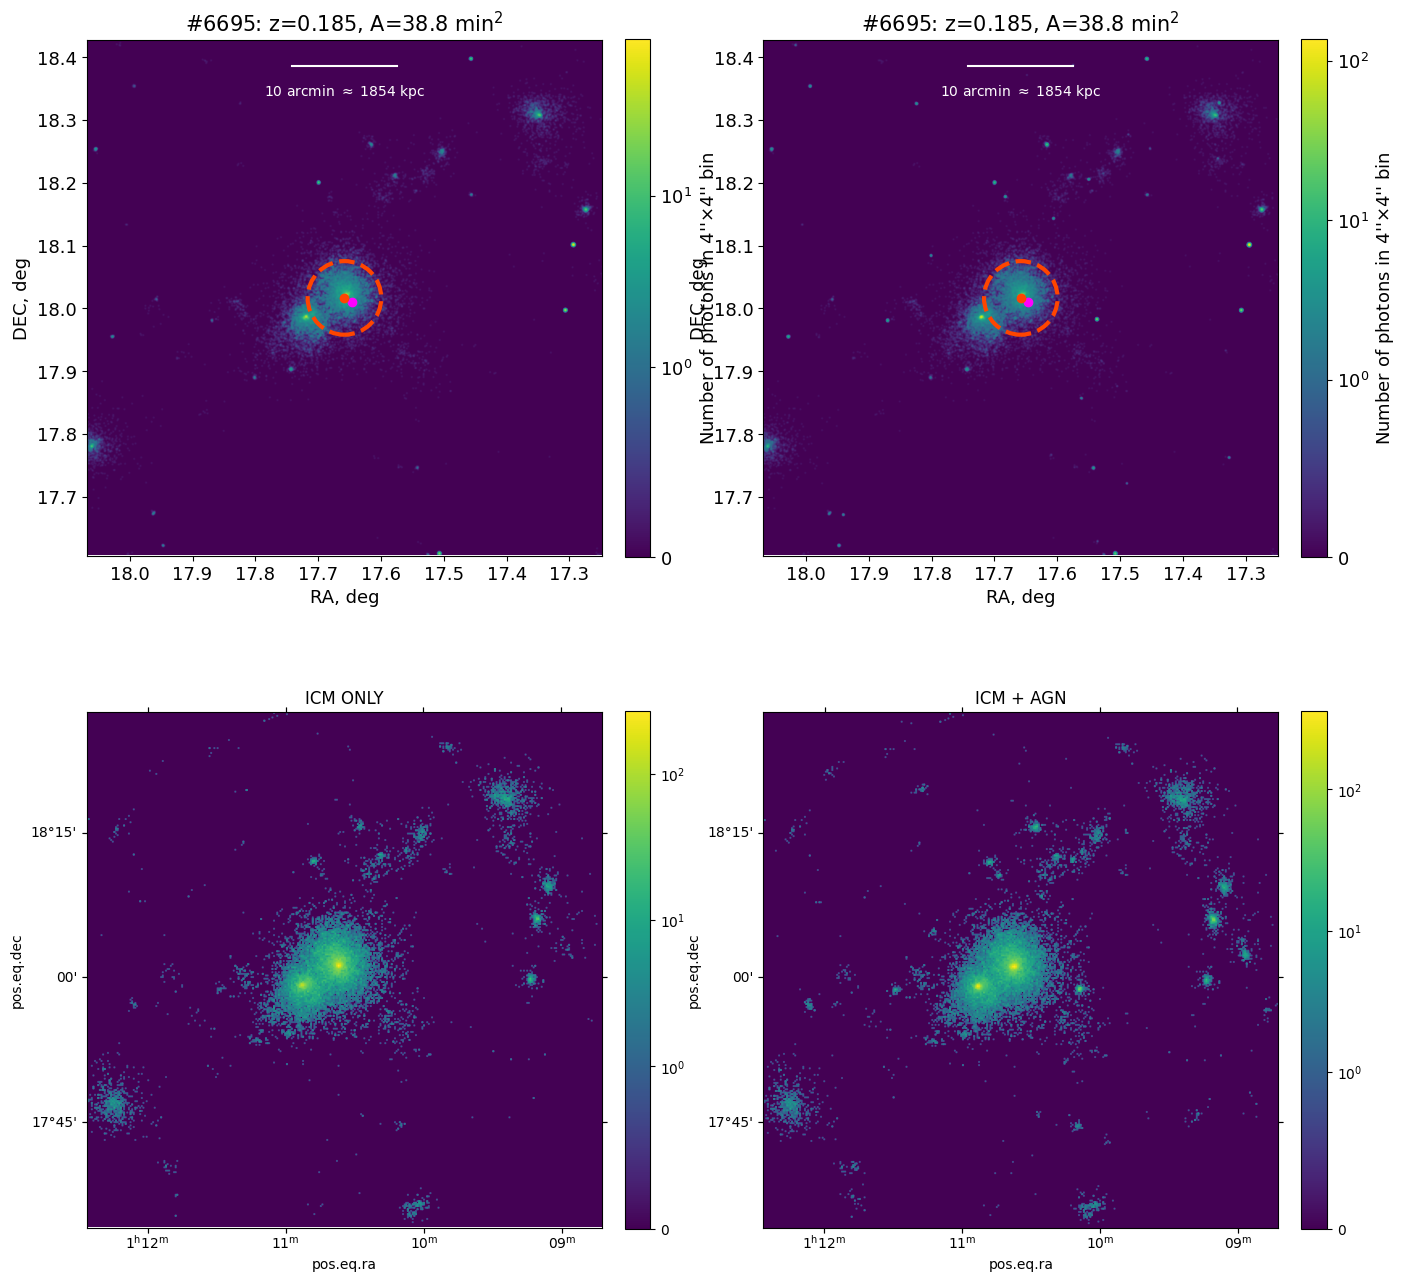

In [58]:
%run -i 'scripts.py'

plt.figure(figsize=(16,16))

cl_num = 6695
RRR = 1.0

plt.subplot(221)
pho_hist = extract_photons_from_cluster(cl_num, 
                                        r = RRR, 
                                        centroid=True, 
                                        delete_superfluous=False, 
                                        draw=True,
                                        draw_additional=False)

plt.subplot(222)
pho_hist = extract_photons_from_cluster(cl_num, 
                                        r = RRR, 
                                        centroid=True, 
                                        delete_superfluous=False, 
                                        draw=True,
                                        draw_additional=False,
                                        withagn=True)


hdul =  fits.open("erosita_img_124.fits")[0]
hdr = hdul.header
image_data = hdul.data
wcs = WCS(hdr)
plt.subplot(223, projection=wcs)
plt.imshow(image_data, origin="lower", norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1))
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlim((250-160, 250+160))
plt.ylim((250-160, 250+160))
plt.title("ICM ONLY")

hdul =  fits.open("erosita_img.fits")[0]
hdr = hdul.header
image_data = hdul.data
wcs = WCS(hdr)
plt.subplot(224, projection=wcs)
plt.imshow(image_data, origin="lower", norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1))
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlim((250-160, 250+160))
plt.ylim((250-160, 250+160))
plt.title("ICM + AGN")

plt.show()

#### Drawing all 84 clusters:

In [123]:
%run -i 'scripts.py'

size = 6

plt.figure(figsize=((size)*7+6*3, 5*12+11*2.5))

draw_84_panels(False)

plt.savefig('panels_filtered.png', format='png', dpi=200, bbox_inches='tight')

plt.show()

  0%|          | 0/84 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

#### Stacking all the clusters:

In [125]:
%run -i 'scripts.py'

length = 1500

total_hist = np.zeros((length, length))

for cl_num in tqdm(clusters.index[:84]):
     
    pho_hist = extract_photons_from_cluster(cl_num, r = 1.0, draw=False, delete_bright_regions=False)
    
    total_hist = np.add(total_hist, pho_hist)

  0%|          | 0/84 [00:00<?, ?it/s]

749.5


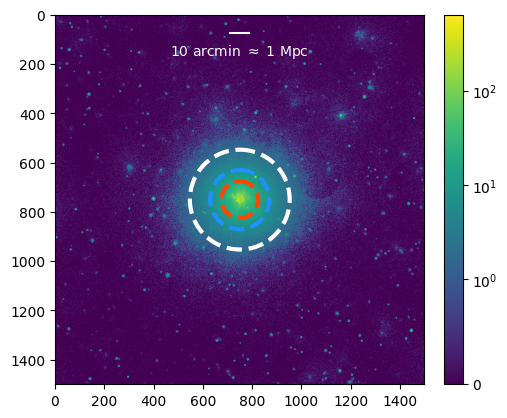

In [126]:
half_length = int(length/2)
r500r = int(half_length/10)

plt.imshow(np.rot90(total_hist), norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1), origin='upper')
plt.colorbar(fraction=0.046, pad=0.04)

plt.gca().add_patch(plt.Circle((half_length, half_length), r500r, 
                               color='orangered', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*1.6, 
                               color='dodgerblue', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*2.7, 
                               color='white', linestyle="--", lw=3, fill = False))

x_s = (plt.gca().get_xlim()[1]+plt.gca().get_xlim()[0])/2
print(x_s)
y_s = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.95+plt.gca().get_ylim()[0]
y_S = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.90+plt.gca().get_ylim()[0]   
plt.plot((x_s+r500r/2, x_s-r500r/2), (y_s, y_s), color='white')
plt.text(x_s, y_S, f'10 arcmin $\\approx$ 1 Mpc', 
         color='white', ha='center', va='center')

plt.show()

#### Here we obtain brightness profile:

In [127]:
%run -i 'scripts.py'

brightness = []

r_pixels_max = 10*r500r

#ring_width = 10

setka = np.geomspace(1, r_pixels_max, 30).astype(int)

c2 = [r_pixels_max, r_pixels_max]

setka

array([  1,   1,   1,   1,   2,   3,   3,   4,   6,   7,   9,  12,  15,
        19,  24,  30,  38,  48,  60,  76,  96, 120, 151, 190, 239, 300,
       378, 475, 596, 750])

<Figure size 640x480 with 0 Axes>

In [128]:
for i in tqdm(range(0, len(setka)-1)):

    k1 = kruzhok(setka[i], c2, total_hist, r_pixels_max-1)
    k2 = kruzhok(setka[i+1], c2, total_hist, r_pixels_max-1)
    ring = k2[0]-k1[0]
    brightness.append(ring.sum()/(sum(k2[1].flatten())-sum(k1[1].flatten())))

  0%|          | 0/29 [00:00<?, ?it/s]

/tmp/ipykernel_4257/3792394201.py:6: RuntimeWarning: invalid value encountered in scalar divide
  brightness.append(ring.sum()/(sum(k2[1].flatten())-sum(k1[1].flatten())))


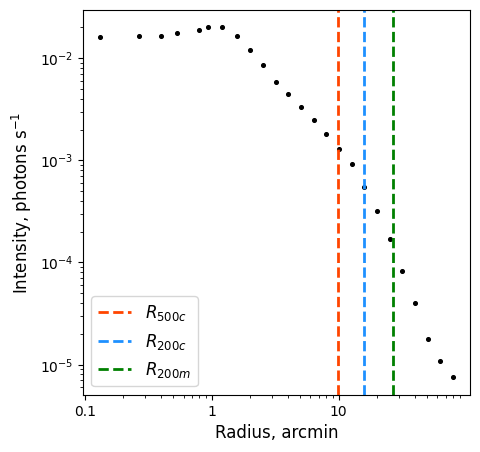

In [129]:
plt.figure(figsize=(5,5))

#r500_pix = int(1000/343000*180/np.pi*3600/4)

# np.linspace(0, r_pixels_max+1, r_pixels_max+1)/r500_pix

#plt.plot(setka[:-1]/r500r*(10*998/1000), np.array(brightness)/10000/(4/60)**2)

#plt.axvline((brightness.index(max(brightness))+1)/r500_pix, ls='--', color='black')

plt.xlabel("Radius, arcmin", fontsize=12)  # "Radius in units of $R_{500}$")
plt.ylabel("Intensity, photons s$^{-1}$", fontsize=12) # "Brightness in relative units")

#plt.axhline(brightness_max, ls='--', color='red', 
#label=f'{threshold*100:.2f} % cutoff\nat brightness = {brightness_max:.2f}')
plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=2)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c}$', lw=2)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m}$', lw=2)

plt.scatter(setka[:-1]/r500r*(10*998/1000), np.array(brightness)/10000, color='black', s=7)

plt.legend(loc=3, fontsize=12)
#plt.subplots_adjust()                 
#plt.tight_layout()
plt.xticks([0.1, 1, 10], [0.1, 1, 10])

plt.show()

#### Conversion factor:

https://arxiv.org/pdf/2012.11627 Churazov+21

https://arxiv.org/pdf/2305.07080 Lyskova+23

In [224]:
%run -i 'scripts.py'

temps = np.logspace(np.log10(0.1), np.log10(12), 101)
flux_ergs = temps * 0
flux_photons = temps * 0
count_rate = temps * 0

df = pd.DataFrame([])

for i in tqdm(range(0, len(temps))):
    
    flux_ergs[i], flux_photons[i], count_rate[i] = calc_l_T(temps[i], 0.3, 2.3, Xplot=False)
                        
    df2 = (pd.DataFrame([[temps[i], flux_ergs[i], flux_photons[i], count_rate[i]]], index=None))
    
    df = pd.concat([df, df2])

df.to_csv('cf(T).csv', sep=' ', header=False, index=False)

  0%|          | 0/101 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

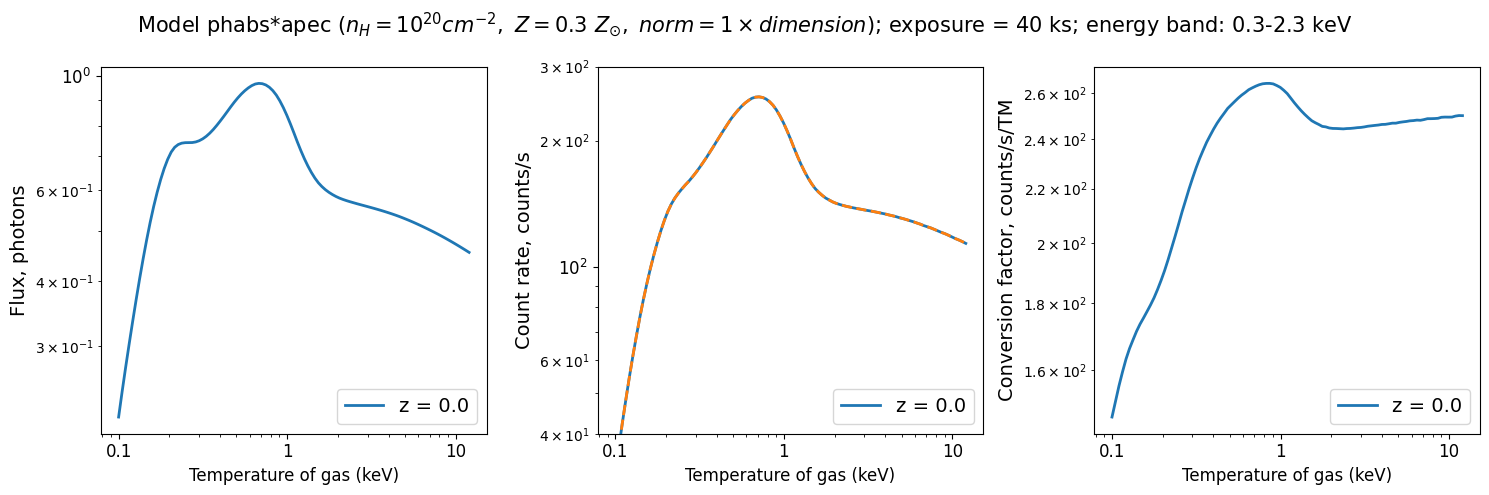

In [138]:
%run -i 'scripts.py'

def add_fancy():

    plt.xlabel('Temperature of gas (keV)', fontsize = 12)
    plt.yticks(size=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks([0.1, 1, 10], [0.1, 1, 10], size=12)
    plt.legend(fontsize=14, loc=4)

plt.figure(figsize=(15,5))

plt.suptitle("Model phabs*apec ($n_H = 10^{20} cm^{-2}, \ Z = 0.3 \ Z_{\odot}, \ norm = 1 \\times dimension$); exposure = 40 ks; energy band: 0.3-2.3 keV", fontsize = 15)

for zt in [0]:

    read_lT = pd.read_csv("cf(T)_z0"+str(zt)+".csv", header=None, delimiter=' ')
    temps1 = read_lT[0].values
    flux_ergs1 = read_lT[1].values
    flux_photons1 = read_lT[2].values
    count_rate1 = read_lT[3].values

    plt.subplot(131)
    #plt.plot(temps1, flux_ergs1, linestyle='-', linewidth=2)
    #plt.ylabel('Flux, ergs/cm$^2$', fontsize = 14)
    #plt.title('Energy flux', fontsize = 15)
    plt.plot(temps1, flux_photons1, linewidth=2, label=f"z = 0."+str(zt))
    plt.ylabel('Flux, photons', fontsize = 14)
    #plt.title('Photon flux', fontsize = 15)
    add_fancy()

    plt.subplot(132)
    plt.plot(temps1, count_rate1, linewidth=2, label=f"z = 0."+str(zt))
    plt.plot(temps1, count_rate1*(1+zt/10)**3, ls='--', lw=2)
    plt.ylabel('Count rate, counts/s', fontsize = 14)
    #plt.title('Photon flux', fontsize = 15)
    plt.ylim(40, 300)
    add_fancy()

    plt.subplot(133)
    plt.plot(temps1, count_rate1/flux_photons1, linewidth=2, label=f"z = 0."+str(zt))
    plt.ylabel('Conversion factor, counts/s/TM', fontsize = 14)
    #plt.title('Count rate', fontsize = 15)
    add_fancy()
    
plt.tight_layout()        
plt.show()

In [ ]:
        # deleting bright regions           
        
        if delete_bright_regions:
        
            number_of_unfiltered_photons = len(dddfff)
        
            # recalculate nmhg relative to centroid
            
            SLICE3["what"] = np.where( (np.abs(SLICE3["RA"]-c_x_1) < half_size) & (np.abs(SLICE3["DEC"]-c_y_1) < half_size),
                                      True, False)
            whattodraw = SLICE3[SLICE3['what'] == True]
            whattodraw = whattodraw.drop("what", axis=1)
            nmhg, _, _ = np.histogram2d(whattodraw["RA"], whattodraw["DEC"], 
                                        bins=int(2*half_size*3600/ang_res),
                                        range=np.array([(cntr[0]-half_size, cntr[0]+half_size),
                                                        (cntr[1]-half_size, cntr[1]+half_size)]))            
            
            #fltr = Tophat2DKernel(2)
            fltr = Gaussian2DKernel(1)
            nmhg = convolve_fft(nmhg, fltr) 

            # some magic ...
            
            #shift = [int((RA_c-cntr[0]+half_size)*3600/ang_res), int((DEC_c-cntr[1]+half_size)*3600/ang_res)]
            shift = [int((half_size)*3600/ang_res), int((half_size)*3600/ang_res)]
            c1 = shift 
                       
            nmhg1 = kruzhok(int(R*3600/ang_res), c1, nmhg, int(R*3600/ang_res)+1)[0]
  
            if draw_additional:
                
                plt.show()
            
                # initial plot in terms of pixels and only circle of R500
        
                plt.figure(figsize=(12,5))
                plt.subplot(121)
                plt.title("nmhg")
                plt.imshow(np.rot90(nmhg), norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1), origin='upper')
                plt.scatter(c1[0], c1[1], color='orangered')
                plt.gca().add_patch(plt.Circle(c1, int(R*3600/ang_res), color='orangered', linestyle="--", lw=3, fill = False))
                plt.colorbar(fraction=0.046, pad=0.04)
                plt.subplot(122)
                plt.title("nmhg1, R = "+str(int(R*3600/ang_res))+" pixels")
                plt.imshow(np.rot90(nmhg1), norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1), origin='upper')
                plt.gca().add_patch(plt.Circle((int(R*3600/ang_res), int(R*3600/ang_res)), 
                                    int(R*3600/ang_res), color='orangered', linestyle="--", lw=3, fill = False))  
                plt.colorbar(fraction=0.046, pad=0.04)
                plt.show()
            
            # searching for cutoff value in one pixel            
            
            threshold = 0.01
            
            beeens = np.geomspace(1, np.max(nmhg1.flatten()), 50)
            amount_in_bin, bin_borders = np.histogram(nmhg1.flatten(), bins = beeens)
            bin_centers = (bin_borders[:-1]+bin_borders[1:])/2
            cumulative = [sum(amount_in_bin[:i]) for i in range(0, len(amount_in_bin))]
            number_cutoff = bin_centers[np.argmin(np.abs(cumulative-cumulative[-1]*threshold))]
            index_cutoff = list(bin_centers).index(number_cutoff)
            threshold_new = sum(amount_in_bin[:index_cutoff]) / cumulative[-1]
           
            if draw_additional:
            
                plt.figure(figsize=(13,5))
                plt.subplot(121)
                plt.hist(nmhg1.flatten(), bins = beeens)
                plt.xlabel(f"Number of photons in {ang_res}''$\\times${ang_res}'' bin")
                plt.ylabel("Amount of such bins")
                plt.yscale("log")
                plt.xscale("log")
                plt.title("Flattened histogram for upper right image")
                plt.subplot(122)
                plt.scatter(bin_centers, cumulative)
                plt.xlabel(f"Number of photons in {ang_res}''$\\times${ang_res}'' bin")
                plt.ylabel("Cumulative distribution")
                plt.yscale("log")
                plt.xscale("log")         
                plt.title(f"$x$-values are added up until their sum\nis right below {threshold*100:.0f} % cutoff")    
                plt.axhline(cumulative[-1], ls='-.', color='green', label="Total sum")
                plt.axhline(cumulative[-1]*threshold, ls='-.', color='red', label=f'Total sum $\\times$ {threshold}')
                plt.axvline(number_cutoff, ls='--', color='red', 
                            label=f'Cutoff at\nnumber = {number_cutoff:.2f};\n{threshold_new*100:.2f}% reached')
                plt.legend(loc=4)
                plt.subplot(121)
                plt.axvline(number_cutoff, ls='--', color='red')
                #plt.tight_layout()
                plt.subplots_adjust()                 
                plt.show()
                        

            # making masks and applying them to images
            
            nmhg_radial = nmhg
            nmhg1_reserve = nmhg1
            
            filter_mask = nmhg <= number_cutoff
            nmhg = nmhg*filter_mask
            
            filter_mask1 = nmhg1 <= number_cutoff
            nmhg1 = nmhg1*filter_mask1
            
            #plt.imshow(np.rot90(filter_mask1))
            #plt.show()            
            
            if draw_additional:
            
                plt.figure(figsize=(11,5))
                plt.subplot(121)
                plt.title("nmhg1 (filtered)")
                plt.imshow(np.rot90(nmhg1), norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1), origin='upper')
                plt.colorbar(fraction=0.046, pad=0.04)
                plt.subplot(122)
                plt.title("nmhg (filtered)")
                plt.imshow(np.rot90(nmhg), norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1), origin='upper')
                plt.colorbar(fraction=0.046, pad=0.04)
                plt.show()
            
            dddfff["RA_pix"] =  (dddfff["RA"]  - cntr[0] + R)*3600/ang_res # - 1
            dddfff["DEC_pix"] = (dddfff["DEC"] - cntr[1] + R)*3600/ang_res # - 1
            
            dddfff["RA_pix"] = dddfff["RA_pix"].astype(int)
            dddfff["DEC_pix"] = dddfff["DEC_pix"].astype(int)
            
            dddfff["stay"] = filter_mask1[dddfff["RA_pix"], dddfff["DEC_pix"]]
            dddfff = dddfff[dddfff["stay"] == True]
                        
            if draw_additional:
            
                plt.figure(figsize=(11,5))
                plt.subplot(121)
                NMHG2, NMHG_X, NMHG_Y , _ = plt.hist2d(dddfff["RA"], dddfff["DEC"],
                                             bins=len(nmhg1),
                                             norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1))
                axesforsmooth = list(plt.gca().get_xlim()) + list(plt.gca().get_ylim())
                #print(axesforsmooth)
                plt.gca().set_aspect('equal', 'box')
                plt.colorbar(fraction=0.046, pad=0.04)
                plt.title('nmhg1 but in RA/DEC')
                plt.scatter(cntr[0], cntr[1], color='orangered', label = 'Centroid')
                                                
            dddfff = dddfff.drop("stay", axis=1) 
            dddfff = dddfff.drop("RA_pix", axis=1)
            dddfff = dddfff.drop("DEC_pix", axis=1)
            
            # number_of_unfiltered_photons
            
            number_of_filtered_photons = len(dddfff)
            percent_of_photons = number_of_filtered_photons/number_of_unfiltered_photons
                                
            if draw_additional and True:     
                plt.show()
                
                NMHG2 = np.rot90(NMHG2)
                plt.imshow(convolve(NMHG2, fltr), 
                           norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1), 
                           origin='upper',
                           extent = axesforsmooth)
                plt.colorbar(fraction=0.046, pad=0.04)
                plt.gca().set_aspect('equal', 'box')
                plt.title('nmhg1 but in RA/DEC convolved')
                plt.show()


In [ ]:
    if delete_bright_regions:
                
        SLICE1["RA_pix"] = ((SLICE1["RA"] - cntr[0] + half_size)*3600/ang_res).astype(int) - 1
        SLICE1["DEC_pix"] = ((SLICE1["DEC"] - cntr[1] + half_size)*3600/ang_res).astype(int) - 1
    
        SLICE1['todraw'] = filter_mask[SLICE1["RA_pix"], SLICE1["DEC_pix"]]
        SLICE1 = SLICE1[SLICE1['todraw'] == True]